In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2012)

In [3]:
# Configure visual settings:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.style.use(['bmh'])

In [4]:
# Load the dataframe
data = pd.read_pickle('assets/clean_data.p')

data.drop(['loc1.timeRestr','loc2.timeRestr','loc1.county','loc2.county','loc1.region','loc2.region','loc1.address','loc2.address','loc1.city','loc2.city','loc1.state','loc2.state','loc1.zipCode','loc2.zipCode','reference_category','move_datetime','loc1.geocodeResultCode','loc2.geocodeResultCode','estMeters1','estMeters2'], axis=1, inplace=True)
data.iloc[0,:]

help_packing                                                            Yes
boxes                                                               40 - 50
furniture                 Sectional Sofa (11'6"x7'10"x2'9"), Desk (5'x2'...
reference                       Good reviews online. Seen truck everywhere.
mention                   Would like to receive two estimates: one for p...
est_hours                                                              3.25
truck                                                              Behemoth
num_movers                                                                3
rate                                                                    200
travel_fee                                                                1
min_hours                                                                 3
loc1.lengthOfWalkOptID                                                    6
loc1.sqFt                                                               800
loc1.elevato

In [5]:
# Except for null values, square footage is good.
data['loc1.sqFt'].isnull().sum()

1890

### Turn estimate of boxes into integer:

Since most estimates of boxes are things like 10 - 20, 20 - 30, use regex to find all numbers in each string, and take their average:

In [6]:
data['boxes'].value_counts()

10 - 20                 3110
20 - 30                 2796
1 - 10                  1812
30 - 40                 1502
40 - 50                  805
None                     707
50 - 60                  468
60 - 70                  222
70 - 80                  149
90 - 100                 126
100 - 125                 85
80 - 90                   80
125 - 150                 47
                          30
150 - 175                 29
200+                      23
175 - 200                 11
0                          8
10-20                      4
20-30                      4
1-10                       3
40-50                      3
16-20                      2
50-60                      2
80 - 90 (revised to        2
20                         2
25                         1
60-70                      1
30-40                      1
40                         1
30 - 50                    1
70                         1
85                         1
Please Select              1
50-70         

In [7]:
import re

In [8]:
def find_boxes(box_string):
    
    pattern = re.compile('\d+')

    foo = re.findall(pattern, box_string)

    return(np.mean([int(x) for x in foo]))


In [9]:
data['boxes'] = data['boxes'].astype(str).apply(find_boxes)

C:\Users\benps\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


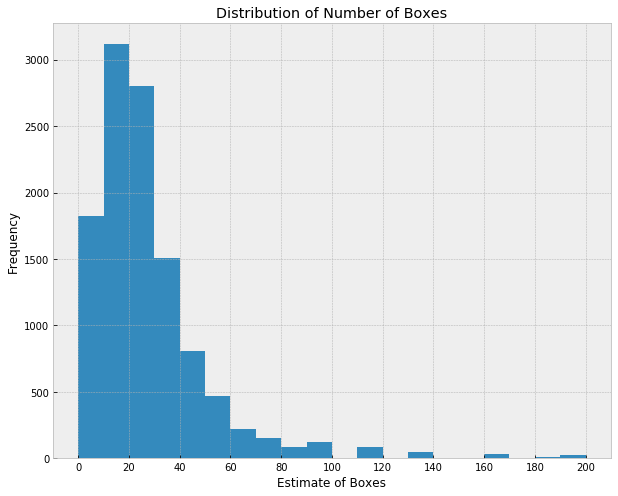

In [10]:
bins = np.arange(0,210,10)


_ = data['boxes'].plot(kind='hist', bins=bins)
_ = plt.title('Distribution of Number of Boxes')
_ = plt.xticks(np.arange(0,210,20))
_ = plt.xlabel('Estimate of Boxes')

In [11]:
# What is this?!
data['loc1.lengthOfWalkOptID'].unique()

array([  6.,   3.,   5.,   2.,   4.,  nan,   7.,   1.,   9.,  10.,   8.])

### Handling elevator size:

In [12]:
def elevator_parser(elev_string):
        if 'medium' in elev_string:
            return('Medium')
        elif 'large' in elev_string:
            return('Large')
        elif 'small' in elev_string:
            return('Small')
        elif 'no' in elev_string:
            return('None')    

In [13]:
data['loc1.elevatorType'] = data['loc1.elevatorType'].apply(elevator_parser)
data['loc2.elevatorType'] = data['loc2.elevatorType'].apply(elevator_parser)

In [14]:
data['loc1.elevatorType'].fillna('None', inplace=True)
data['loc2.elevatorType'].fillna('None', inplace=True)

In [15]:
data['loc1.elevatorType'].value_counts() + data['loc2.elevatorType'].value_counts()

None      12505
Medium     6479
Large      4075
Small      1031
dtype: int64

### Handling stairs

In [16]:
def stair_parser(stair_string):
    if type(stair_string) == int:
        return(stair_string)
    if 'step' in stair_string:
        return(1)
    elif 'stair' in stair_string:
        return(1)
    elif stair_string == '':
        return(0)
    elif stair_string == 'None':
        return(0)
    elif type(stair_string) == str:
        pattern = re.compile('\d+')

        try:
            foo = re.search(pattern, stair_string).group()
        except:
            foo = 0
        return(int(foo))
              
    else:
        return(0)


In [17]:
data['loc1.stairs'] = data['loc1.stairs'].apply(stair_parser)

data['loc2.stairs'] = data['loc1.stairs'].apply(stair_parser)

In [22]:
stair_multiplier = [1 if x == 'None' else 0 for x in data['loc1.elevatorType']]

data['loc1.stairs'] = data['loc1.stairs'] * stair_multiplier

In [29]:
stair_multiplier = [1 if x == 'None' else 0 for x in data['loc2.elevatorType']]

data['loc2.stairs'] = data['loc2.stairs'] * stair_multiplier

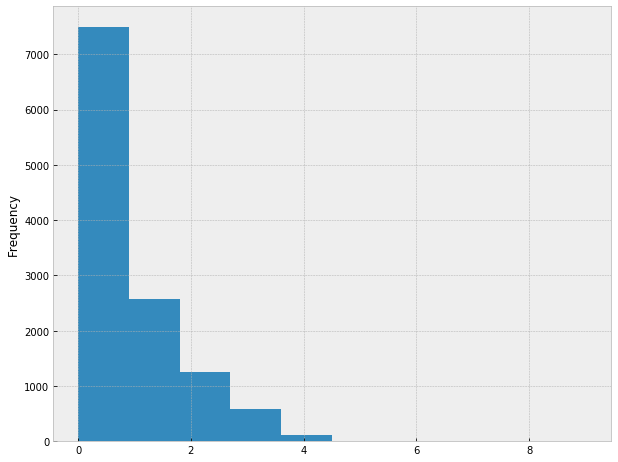

In [30]:
data['loc1.stairs'].plot(kind='hist')

### Parking Type

In [31]:
def parking_type_parser(ptype_string):
    if ptype_string not in ['Driveway','Loading Dock','Parking Lot','Street']:
        return('Not specified')

    else:
        return(ptype_string)


In [32]:
data['loc1.parkingType'][3] in ['Driveway','Loading Dock','Parking Lot','Street']

True

In [33]:
data['loc1.parkingType'] = data['loc1.parkingType'].apply(parking_type_parser)
data['loc2.parkingType'] = data['loc2.parkingType'].apply(parking_type_parser)

In [34]:
data['loc1.parkingType'].value_counts() + data['loc2.parkingType'].value_counts()

Street           9032
Loading Dock     8309
Driveway         3507
Parking Lot      2631
Not specified     611
dtype: int64

## Handling placetype

In [35]:
def place_type_parser(ptype_string):
    ptype_string = ptype_string.lower()
    ptype_string = ptype_string.replace('apt','apartment')
    pattern = re.compile('\d+ bedroom apartment \+')
    if re.match(pattern, ptype_string):
        return(ptype_string) 
    elif 'studio' in ptype_string:
        return('1 bedroom apartment')
    elif re.match('\d+ bedroom apartment', ptype_string):
        return(ptype_string)
    elif re.match('\d+ bedroom house', ptype_string):
        return(ptype_string)
    elif re.search('storage', ptype_string):
        return('Storage')
    elif re.search('warehouse', ptype_string):
        return('Storage')
    elif re.match('\d+ bedroom', ptype_string):
        return(ptype_string + ' apartment')
    else:
        return('Other')

In [36]:
data['loc1.placeType'] = data['loc1.placeType'].apply(place_type_parser)

data['loc2.placeType'] = data['loc2.placeType'].apply(place_type_parser)

In [37]:
data.iloc[0,:]

help_packing                                                            Yes
boxes                                                                    45
furniture                 Sectional Sofa (11'6"x7'10"x2'9"), Desk (5'x2'...
reference                       Good reviews online. Seen truck everywhere.
mention                   Would like to receive two estimates: one for p...
est_hours                                                              3.25
truck                                                              Behemoth
num_movers                                                                3
rate                                                                    200
travel_fee                                                                1
min_hours                                                                 3
loc1.lengthOfWalkOptID                                                    6
loc1.sqFt                                                               800
loc1.elevato

### Pickle dat shit!

In [38]:
data.to_pickle('assets/engineered_data1.p')